<a href="https://colab.research.google.com/github/khushboo0824/ABSA/blob/main/bgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install setfit
!pip install pyabsa
!pip install transformers
!pip install simplemma
!pip install nltk

In [ ]:
import pandas as pd
import requests
import xml.etree.ElementTree as ET
import math
import time
import ast
import string
import pickle
import os.path
import matplotlib.pyplot as plt

import transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback
import torch.nn.functional as F
from setfit import AbsaModel, AbsaTrainer, TrainingArguments
from pyabsa import available_checkpoints, TaskCodeOption, AspectTermExtraction as ATEPC, ModelSaveOption, DeviceTypeOption
from datasets import load_dataset
import simplemma
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore", category=ImportWarning)

transformers.logging.set_verbosity_error()

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


No CUDA GPU found in your device


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

[2024-09-02 21:20:45] (2.4.1.post1) PyABSA(2.4.1.post1): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.x versions, e.g., pip install pyabsa<2.0 -U




Try to downgrade transformers<=4.29.0.






/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


In [ ]:
df_boardgames = pd.read_csv('boardgames_ranks.csv')

In [ ]:
df_boardgames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157074 entries, 0 to 157073
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   157074 non-null  int64  
 1   name                 157074 non-null  object 
 2   yearpublished        157074 non-null  int64  
 3   rank                 157074 non-null  int64  
 4   bayesaverage         157074 non-null  float64
 5   average              157074 non-null  float64
 6   usersrated           157074 non-null  int64  
 7   is_expansion         157074 non-null  int64  
 8   abstracts_rank       1438 non-null    float64
 9   cgs_rank             360 non-null     float64
 10  childrensgames_rank  1060 non-null    float64
 11  familygames_rank     3242 non-null    float64
 12  partygames_rank      900 non-null     float64
 13  strategygames_rank   2955 non-null    float64
 14  thematic_rank        1661 non-null    float64
 15  wargames_rank    

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df = df_boardgames[['id', 'name', 'rank', 'bayesaverage', 'average', 'usersrated']]
df.describe(percentiles=[.10, .25, .50, .75, .90]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
id,157074.0,190854.971689,135101.911762,1.0,17106.3,43023.75,182947.5,312567.750000,377434.100000,426755.00000
rank,157074.0,2290.834581,5976.818017,0.0,0.0,0.00,0.0,0.000000,11118.700000,26826.00000
bayesaverage,157074.0,1.350312,2.422708,0.0,0.0,0.00,0.0,0.000000,5.570750,8.41479
average,157074.0,5.022856,3.041781,0.0,0.0,3.00,6.0,7.227485,8.012939,10.00000
usersrated,157074.0,185.118384,1763.055687,0.0,0.0,1.00,4.0,26.000000,151.000000,128672.00000


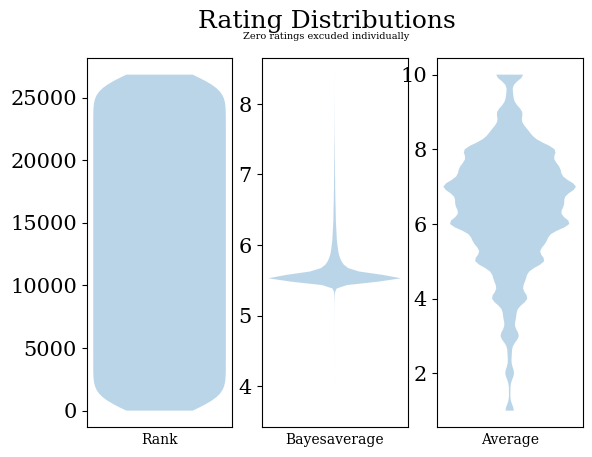

In [ ]:
# Plotting the ranking distributions without 0 ranks
fig, ax = plt.subplots(1, 3, sharex=False)

for i, feature in enumerate(['rank', 'bayesaverage', 'average']):

    plot_data = df[[feature]].query(f'{feature} != 0')
    ax[i].violinplot(plot_data, showextrema=False)
    ax[i].set_xlabel(f'{feature.title()}', size=10)

    ax[i].set_xticks([])

_ = plt.text(.5, .92, 'Zero ratings excuded individually', transform=fig.transFigure, horizontalalignment='center', size=7)
_ = fig.suptitle('Rating Distributions')

In [ ]:
df_sorted = df_boardgames.sort_values(by='bayesaverage', ascending=False)

In [ ]:
df_sorted[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
0,224517,Brass: Birmingham,2018,1,8.41479,8.59552,46799,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
104127,247030,Terraforming Mars: Prelude,2018,0,8.40603,8.84660,15374,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,161936,Pandemic Legacy: Season 1,2015,2,8.37768,8.52593,53788,0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN
2,174430,Gloomhaven,2017,3,8.34962,8.58507,62580,0,NaN,NaN,NaN,NaN,NaN,4.0,2.0,NaN
3,342942,Ark Nova,2021,4,8.33519,8.53477,44675,0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
4,233078,Twilight Imperium: Fourth Edition,2017,5,8.24000,8.59945,24139,0,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN
5,316554,Dune: Imperium,2020,6,8.23076,8.43514,46480,0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
137817,363622,The Castles of Burgundy: Special Edition,2023,0,8.21430,9.15168,6513,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,167791,Terraforming Mars,2016,7,8.21008,8.35695,100058,0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN
7,115746,War of the Ring: Second Edition,2011,8,8.18601,8.54119,21621,0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0


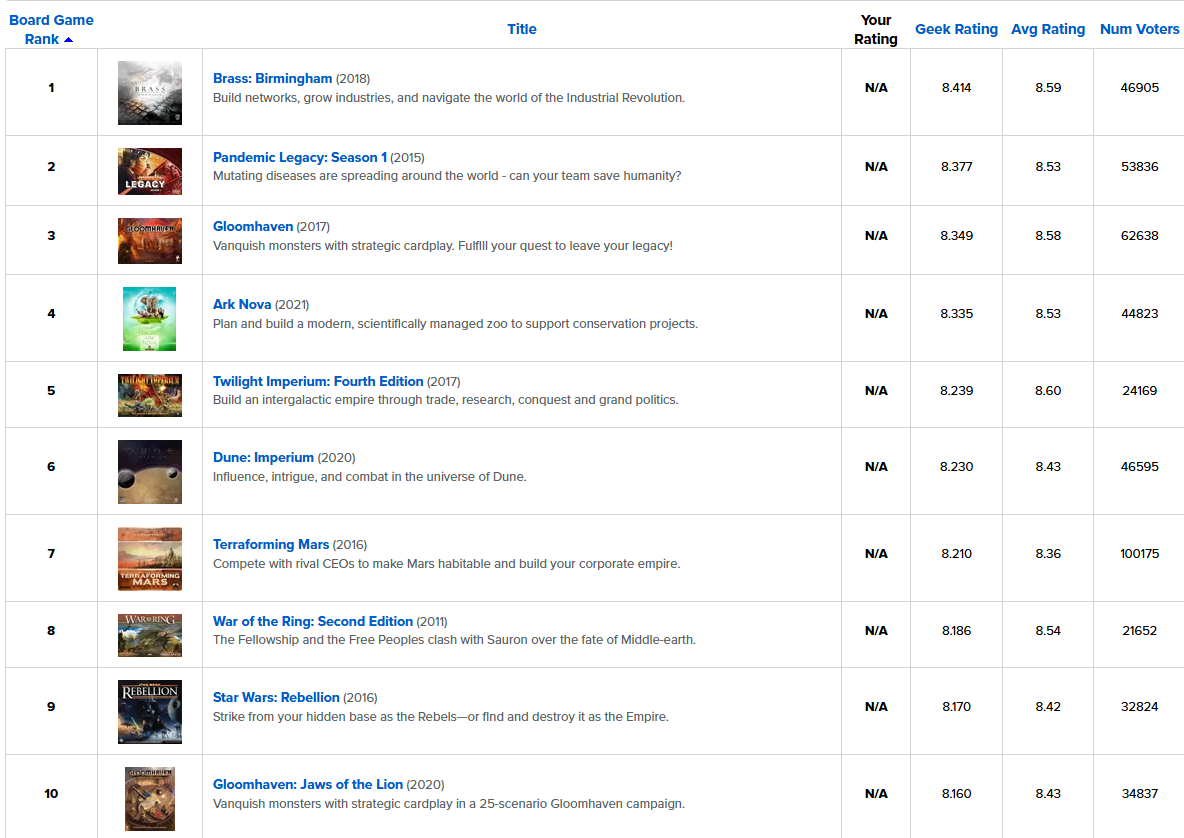

In [ ]:
bg10 = df_boardgames[:10]

In [ ]:
bg10

,id,name,yearpublished,rank,bayesaverage,average,usersrated,is_expansion,abstracts_rank,cgs_rank,childrensgames_rank,familygames_rank,partygames_rank,strategygames_rank,thematic_rank,wargames_rank
0,224517,Brass: Birmingham,2018,1,8.41479,8.59552,46799,0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,161936,Pandemic Legacy: Season 1,2015,2,8.37768,8.52593,53788,0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN
2,174430,Gloomhaven,2017,3,8.34962,8.58507,62580,0,NaN,NaN,NaN,NaN,NaN,4.0,2.0,NaN
3,342942,Ark Nova,2021,4,8.33519,8.53477,44675,0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
4,233078,Twilight Imperium: Fourth Edition,2017,5,8.24000,8.59945,24139,0,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN
5,316554,Dune: Imperium,2020,6,8.23076,8.43514,46480,0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
6,167791,Terraforming Mars,2016,7,8.21008,8.35695,100058,0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN
7,115746,War of the Ring: Second Edition,2011,8,8.18601,8.54119,21621,0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0
8,187645,Star Wars: Rebellion,2016,9,8.17033,8.41837,32787,0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
9,291457,Gloomhaven: Jaws of the Lion,2020,10,8.15997,8.43210,34777,0,NaN,NaN,NaN,NaN,NaN,9.0,7.0,NaN


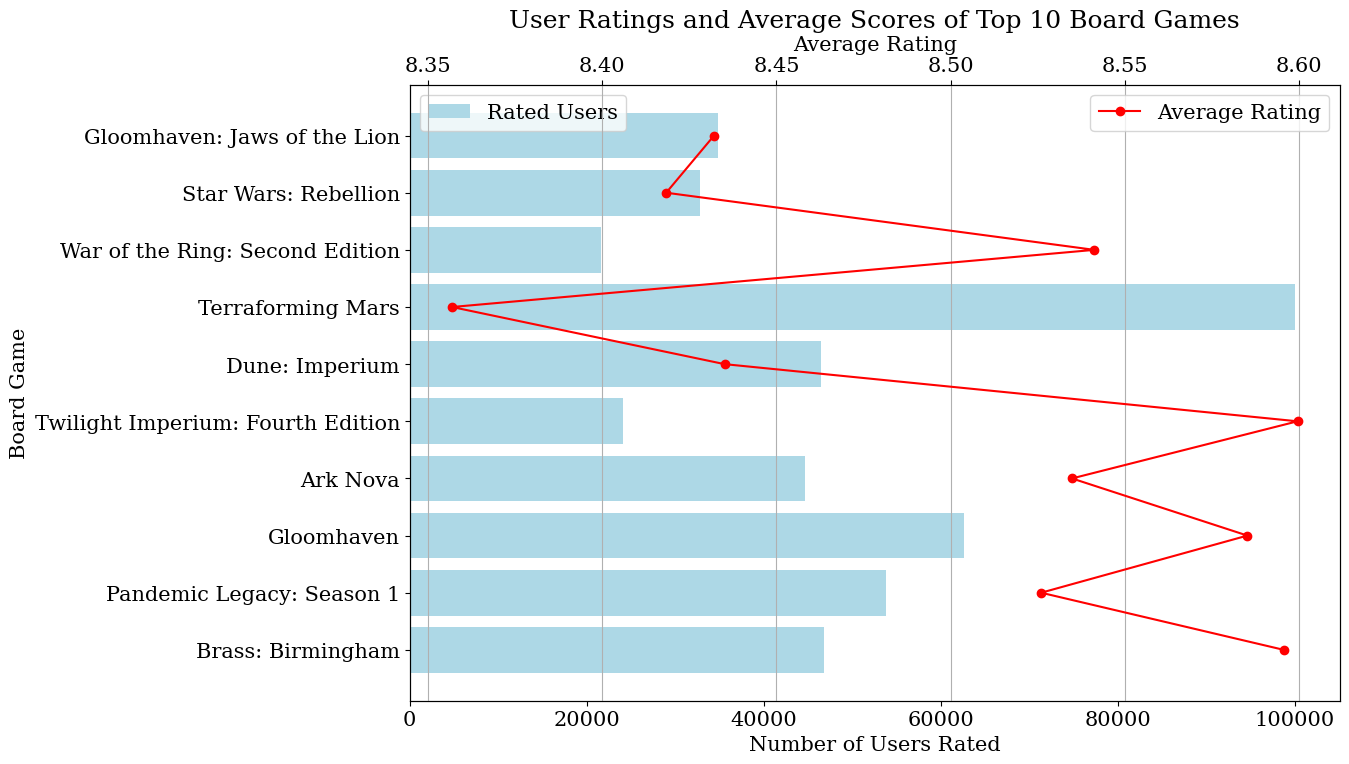

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.barh(bg10['name'], bg10['usersrated'], color='lightblue', label='Rated Users')
ax1.set_xlabel('Number of Users Rated')
ax1.set_ylabel('Board Game')
ax1.set_title('User Ratings and Average Scores of Top 10 Board Games')


ax2 = ax1.twiny()  # twiny() is used to create a secondary x-axis
ax2.plot(bg10['average'], bg10['name'], color='red', marker='o', linestyle='-', label='Average Rating')
ax2.set_xlabel('Average Rating')


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(axis='x')

plt.show()


Downloading the comments for top 10 games

In [ ]:
def donwload_game_comments(game_id):
    comments=[]
    base_url = f'https://api.geekdo.com/xmlapi2/thing?type=boardgame&id={game_id}&comments=1'
    print(f'Downloading comments for game with id {game_id}')
    r = requests.get(base_url)
    # parse downloaded xml
    root = ET.fromstring(r.content)
    # extract the total number of comments for that game
    number_of_comments = int(root[0].find('comments').attrib['totalitems'])
    # calculate the number of pages to request to download all comments
    number_of_pages = math.ceil(number_of_comments / 100)
    time.sleep(1)

    for i in range(number_of_pages):
        # create url for the next page
        url = f'{base_url}&page={i+1}'
        while(True):
            r = requests.get(url)
            # parse downloaded xml
            root = ET.fromstring(r.content)
            # iterate over comments to store them
            for comment in root.iter('comment'):
                comment.attrib['boardgame_id'] = game_id
                comments.append(comment.attrib)
            print(f"{len(comments)}/{number_of_comments}")
            time.sleep(1.5)
            if len(list(root.iter('comment')))>0:
                break
            else:
                print('repeating page download since no comment was received')

    if len(comments)!=number_of_comments:
        print(f'Failed to download ALL comments for game with id: {game_id}')
    return pd.DataFrame(comments)

In [ ]:
if not os.path.isfile('boardgames_comments.csv'):
    df_comments = pd.DataFrame()
    for i,boardgame in bg10.iterrows():
        df_game_comments = donwload_game_comments(boardgame['id'])
        df_comments = pd.concat([df_comments, df_game_comments])
    df_comments.to_csv('boardgames_comments.csv')
else:
    df_comments = pd.read_csv('boardgames_comments.csv',index_col=0)

100/6498
200/6498
300/6498
400/6498
500/6498
600/6498
700/6498
800/6498
900/6498
1000/6498
1100/6498
1200/6498
1300/6498
1400/6498
1500/6498
1600/6498
1700/6498
1800/6498
1900/6498
2000/6498
2100/6498
2200/6498
2300/6498
2400/6498
2500/6498
2600/6498
2700/6498
2800/6498
2900/6498
3000/6498
3100/6498
3200/6498
3300/6498
3400/6498
3500/6498
3600/6498
3700/6498
3800/6498
3900/6498
4000/6498
4100/6498
4200/6498
4300/6498
4400/6498
4500/6498
4600/6498
4700/6498
4800/6498
4900/6498
5000/6498
5100/6498
5200/6498
5300/6498
5400/6498
5500/6498
5600/6498
5700/6498
5800/6498
5900/6498
6000/6498
6100/6498
6200/6498
6300/6498
6400/6498
6498/6498
100/8024
200/8024
300/8024
400/8024
500/8024
600/8024
700/8024
800/8024
900/8024
1000/8024
1100/8024
1200/8024
1300/8024
1400/8024
1500/8024
1600/8024
1700/8024
1800/8024
1900/8024
2000/8024
2100/8024
2200/8024
2300/8024
2400/8024
2500/8024
2600/8024
2700/8024
2800/8024
2900/8024
3000/8024
3100/8024
3200/8024
3300/8024
3400/8024
3500/8024
3600/8024
3700/802

In [ ]:
df_comments = pd.read_csv('boardgames_comments.csv',index_col=0)

In [ ]:
df_comments

,username,rating,value,boardgame_id
0,1 Family Meeple,NaN,SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...,224517
1,13inha,NaN,G,224517
2,1bez,10.0,"Great game, full controllo of your strategy th...",224517
3,1x0r,NaN,Location: MSK,224517
4,2bit,7.5,"Very clever game, enjoyable overall. Plus poi...",224517
...,...,...,...,...
4945,Zvonmirus,7.5,Only played the beginning scenarios with my el...,291457
4946,Zygomax,NaN,BGS Prize Nov. 2021,291457
4947,_Kenneth,9.5,Cooperative Legacy (2P-3P) ✓ Completion,291457
4948,_LSK_,5.0,Too hard under the rules in the game and a bit...,291457


cleaning the comments

In [ ]:
import logging


logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

logger = logging.getLogger('comment_cleaning')


In [ ]:
!pip install langid
from langid.langid import LanguageIdentifier, model
import pandas as pd




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=90e390b97077ec24a6acb3f7d549538ebfdb8cc94b6c9d69f9c2304e5f90dc77
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


/usr/local/lib/python3.10/dist-packages/google/colab/_pip.py:86: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/langid-1.1.6.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [ ]:
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

def clean_comments_df(df_comments: pd.DataFrame) -> pd.DataFrame:
    """
    This function classifies the language of comments from a given DataFrame.

    Args:
        df_comments: A pandas DataFrame containing at least one column with comments to be classified.
                     The column should be named 'value'.

    Returns:
        df_comments: The original DataFrame with additional 'LANGUAGE' and 'PROBABILITY' columns.
    """
    try:

        df_comments['value'] = df_comments['value'].fillna('').astype(str)


        df_comments[['LANGUAGE', 'PROBABILITY']] = df_comments['value'].apply(
            lambda x: pd.Series(identifier.classify(x))
        )

        print("Language classification completed.")


        print(df_comments.head())

        return df_comments

    except Exception as e:
        logger.error(f"Error: {e}")
        return df_comments


In [ ]:
cleaned_df_comments = clean_comments_df(df_comments)
cleaned_df_comments[:25]

Language classification completed.
          username  rating                                              value  \
0  1 Family Meeple     NaN  SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...   
1           13inha     NaN                                                  G   
2             1bez    10.0  Great game, full controllo of your strategy th...   
3             1x0r     NaN                                      Location: MSK   
4             2bit     7.5  Very clever game, enjoyable overall.  Plus poi...   

   boardgame_id LANGUAGE  PROBABILITY  
0        224517       en     1.000000  
1        224517       en     0.169462  
2        224517       en     1.000000  
3        224517       en     0.169462  
4        224517       en     1.000000  


,username,rating,value,boardgame_id,LANGUAGE,PROBABILITY
0,1 Family Meeple,NaN,SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...,224517,en,1.000000
1,13inha,NaN,G,224517,en,0.169462
2,1bez,10.0,"Great game, full controllo of your strategy th...",224517,en,1.000000
3,1x0r,NaN,Location: MSK,224517,en,0.169462
4,2bit,7.5,"Very clever game, enjoyable overall. Plus poi...",224517,en,1.000000
5,2d20,9.0,Brilliant! Fits right into my wheelhouse all ...,224517,en,1.000000
6,35tango,10.0,Absolutely brilliant! I never played the orig...,224517,en,1.000000
7,4characters,5.0,I prefer old school Brass or AoI. I do like th...,224517,en,1.000000
8,4ndroid,8.0,Sold,224517,en,0.169462
9,5mokus,6.0,The game itself is not interesting enough to l...,224517,en,1.000000


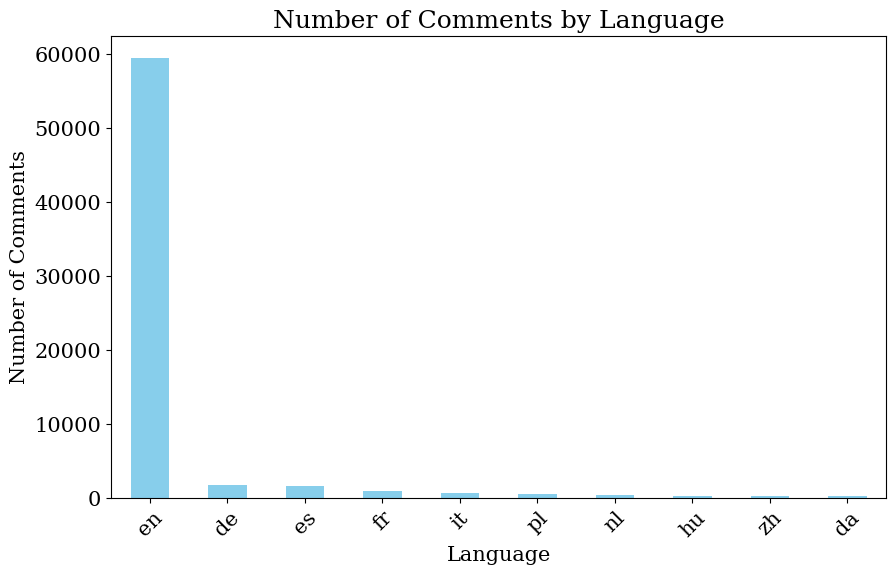

In [ ]:
def plot_language_distribution(df_comments: pd.DataFrame, top_n: int = 10):
    """
    This function plots the distribution of comments by language.

    Args:
        df_comments: A pandas DataFrame containing the 'LANGUAGE' column.
    """
    try:

        if 'LANGUAGE' not in df_comments.columns:
            print("LANGUAGE column not found in DataFrame.")
            return


        language_counts = df_comments['LANGUAGE'].value_counts().head(top_n)

        # Plotting the distribution
        plt.figure(figsize=(10, 6))
        language_counts.plot(kind='bar', color='skyblue')
        plt.title('Number of Comments by Language')
        plt.xlabel('Language')
        plt.ylabel('Number of Comments')
        plt.xticks(rotation=45)
        plt.show()

    except Exception as e:
        print(f"Error while plotting: {e}")


# Plot the distribution of languages
plot_language_distribution(cleaned_df_comments, top_n=10)


Filtering the English comments

In [ ]:
total_comments = cleaned_df_comments.shape[0]
# Count comments that are not in English
non_english_count = cleaned_df_comments[cleaned_df_comments['LANGUAGE'] != 'en'].shape[0]

# Calculate percentage of non-English comments
non_english_percentage = (non_english_count / total_comments) * 100 if total_comments > 0 else 0
print(f"Total comments: {total_comments}")
print(f"Number of non-English comments: {non_english_count}")
print(f"Percentage of non-English comments: {non_english_percentage:.2f}%")


Total comments: 68868
Number of non-English comments: 9451
Percentage of non-English comments: 13.72%


In [ ]:
# Filter out English commen
comments_df = cleaned_df_comments[cleaned_df_comments['LANGUAGE'] == 'en']


In [ ]:
comments_df

,username,rating,value,boardgame_id,LANGUAGE,PROBABILITY
0,1 Family Meeple,NaN,SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...,224517,en,1.000000
1,13inha,NaN,G,224517,en,0.169462
2,1bez,10.0,"Great game, full controllo of your strategy th...",224517,en,1.000000
3,1x0r,NaN,Location: MSK,224517,en,0.169462
4,2bit,7.5,"Very clever game, enjoyable overall. Plus poi...",224517,en,1.000000
...,...,...,...,...,...,...
4943,ZuluXray,NaN,co-op,291457,en,0.399010
4944,zuriad,10.0,Nice for young / new players,291457,en,0.886989
4945,Zvonmirus,7.5,Only played the beginning scenarios with my el...,291457,en,1.000000
4948,_LSK_,5.0,Too hard under the rules in the game and a bit...,291457,en,1.000000


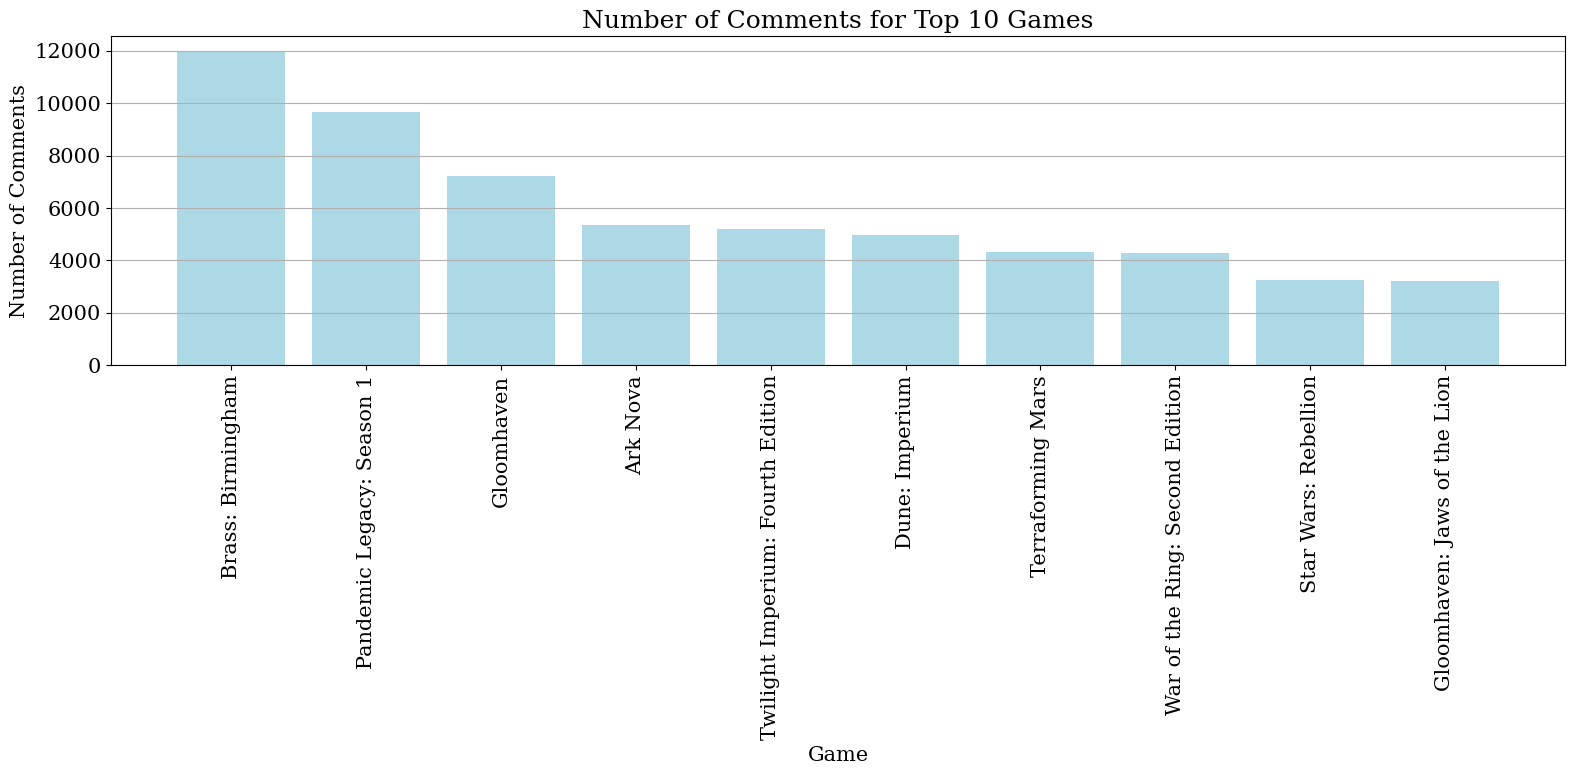

In [ ]:
#  Merging the two DataFrames to associate comments with the top 10 games
merged_df = comments_df.merge(bg10, left_on='boardgame_id', right_on='id', how='inner')

game_comments_count = merged_df['boardgame_id'].value_counts().head(10)
plot_data = merged_df[['boardgame_id', 'name']].drop_duplicates()  # Keep unique boardgame_id and names
plot_data['comment_count'] = game_comments_count.values

plt.figure(figsize=(16, 8))
plt.bar(plot_data['name'], plot_data['comment_count'], color='lightblue')
plt.title('Number of Comments for Top 10 Games')
plt.xlabel('Game')
plt.ylabel('Number of Comments')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


Sentiment Analysis of the comments

In [ ]:
from transformers import pipeline

# Load the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Function to apply sentiment analysis to each comment
def apply_sentiment_analysis(comment):
    truncated_comment = comment[:512]
    result = sentiment_pipeline(truncated_comment)
    label = result[0]['label']
    score = result[0]['score']
    return label, score

# Apply sentiment analysis to each comment
comments_df['sentiment_label'] = comments_df['value'].apply(lambda x: apply_sentiment_analysis(x)[0])
comments_df['sentiment_score'] = comments_df['value'].apply(lambda x: apply_sentiment_analysis(x)[1])

# Display the updated DataFrame
print(comments_df[['value', 'sentiment_label', 'sentiment_score']])

<ipython-input-22-81672cec8c33>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_df['sentiment_label'] = comments_df['value'].apply(lambda x: apply_sentiment_analysis(x)[0])


                                                  value sentiment_label  \
0     SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...        NEGATIVE   
1                                                     G        POSITIVE   
2     Great game, full controllo of your strategy th...        POSITIVE   
3                                         Location: MSK        NEGATIVE   
4     Very clever game, enjoyable overall.  Plus poi...        POSITIVE   
...                                                 ...             ...   
4943                                              co-op        POSITIVE   
4944                       Nice for young / new players        POSITIVE   
4945  Only played the beginning scenarios with my el...        POSITIVE   
4948  Too hard under the rules in the game and a bit...        NEGATIVE   
4949                              Fiddly and repetitive        NEGATIVE   

      sentiment_score  
0            0.994231  
1            0.888061  
2            0.999805  
3  

<ipython-input-22-81672cec8c33>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_df['sentiment_score'] = comments_df['value'].apply(lambda x: apply_sentiment_analysis(x)[1])


Sentiment Analysis of War of the Ring: Second Edition

In [ ]:
game_id = 115746
# Filter the comments DataFrame for  specific game ID
game_df = comments_df[comments_df['boardgame_id'] == game_id]
print(game_df[['value', 'sentiment_label', 'sentiment_score']])

                                                  value sentiment_label  \
0     -0,5 for too soft plastic figures.  They are d...        NEGATIVE   
1                               Organized; FoldedSpace.        NEGATIVE   
2                           BGG Spring 2019 VFM (trade)        NEGATIVE   
3     Great strategy game but slightly biased agains...        POSITIVE   
4     One of the best thematic implementations... yo...        POSITIVE   
...                                                 ...             ...   
3714                           with Folded Space Insert        NEGATIVE   
3715  (first edition comments) Dripping with theme, ...        NEGATIVE   
3718                              #tolearn #game-group         POSITIVE   
3719                    Too heavy for a Thematic bg....        NEGATIVE   
3720  Prior to 2020: 2 plays  This is one of the har...        NEGATIVE   

      sentiment_score  
0            0.999794  
1            0.973444  
2            0.952975  
3  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Aspect extraction from all the comments- spaCy


In [ ]:
!pip install spacy
!pip install spacy vaderSentiment
import spacy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/google/colab/_pip.py:86: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/vaderSentiment-3.3.2.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [ ]:
comments_df = pd.DataFrame(comments_df)

In [ ]:
def extract_aspects(comment):
    doc = nlp(comment)
    aspects = {"positive": [], "negative": []}

    for token in doc:
        if token.pos_ in ["NOUN", "ADJ"]:  # Include nouns and adjectives as aspects
            sentiment_score = sentiment_analyzer.polarity_scores(token.text)['compound']
            if sentiment_score >= 0.05:
                aspects["positive"].append(token.text.lower())  # Use lower case for uniformity
            elif sentiment_score <= -0.05:
                aspects["negative"].append(token.text.lower())

    return aspects

def get_top_aspects_by_sentiment(df):
    all_aspects = {
        "positive": [],
        "negative": []
    }

    # Collect aspects by boardgame_id
    for _, row in df.iterrows():
        aspects = extract_aspects(row['value'])
        all_aspects["positive"].extend(aspects["positive"])
        all_aspects["negative"].extend(aspects["negative"])

    # Count and rank aspects
    positive_counts = Counter(all_aspects["positive"])
    negative_counts = Counter(all_aspects["negative"])

    top_positive_aspects = [aspect for aspect, count in positive_counts.most_common(10)]
    top_negative_aspects = [aspect for aspect, count in negative_counts.most_common(10)]

    return top_positive_aspects, top_negative_aspects


In [ ]:
from collections import Counter
# Process the DataFrame to get top aspects by sentiment
results = {}
for boardgame_id in comments_df['boardgame_id'].unique():
    subset_df = comments_df[comments_df['boardgame_id'] == boardgame_id]
    top_positive, top_negative = get_top_aspects_by_sentiment(subset_df)
    results[boardgame_id] = {
        "top_positive": top_positive,
        "top_negative": top_negative
    }


In [ ]:
results_df = pd.DataFrame(results)


In [ ]:
results_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,boardgame_id,top_positive,top_negative
0,224517,"good,great,play,best,original,fun,interesting,...","hard,difficult,bad,demand,boring,tense,wrong,l..."
1,161936,"great,fun,good,best,amazing,play,interesting,p...","bad,difficult,hard,tension,difficulty,risk,ten..."
2,174430,"great,fun,good,best,play,interesting,amazing,b...","combat,hard,repetitive,bad,enemies,difficult,d..."
3,342942,"good,great,fun,play,luck,plays,best,interestin...","bad,hard,negative,problem,difficult,low,limite..."
4,233078,"great,good,fun,best,play,better,friends,worth,...","combat,hard,bad,battles,war,difficult,problem,..."
5,316554,"good,great,fun,play,best,interesting,luck,bett...","combat,conflict,bad,tense,tension,battle,hard,..."
6,167791,"great,good,fun,play,best,better,interesting,lu...","bad,hard,poor,problem,low,difficult,boring,ter..."
7,115746,"great,good,best,play,fun,fan,amazing,plays,bet...","war,combat,hard,tense,difficult,bad,battle,ris..."
8,187645,"great,fun,good,play,best,fan,original,amazing,...","combat,wars,rebels,rebel,rebellion,war,battles..."
9,291457,"great,good,fun,original,best,better,play,easy,...","combat,hard,repetitive,bad,enemies,difficult,d..."


Abspect based sentiment analysis

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load ABSA model and tokenizer
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

# Load traditional sentiment analysis model
sentiment_model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_pipeline = pipeline("sentiment-analysis", model=sentiment_model_path, tokenizer=sentiment_model_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
aspects = ['LUCK', 'BOOKKEEPING', 'DOWNTIME', 'INTERACTION', 'BASH THE LEADER','COMPLICATED', 'COMPLEX']

# Function to extract aspects from comments
def idx_extractor(string, labels):
    string = string.lower()
    for l in labels:
        if l.lower() in string:
            return l
    return None
comments_df.loc[:, 'ASPECT'] = comments_df['value'].apply(lambda x: idx_extractor(x, aspects))

<ipython-input-13-7bb353ac6238>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_df.loc[:, 'ASPECT'] = comments_df['value'].apply(lambda x: idx_extractor(x, aspects))


In [ ]:
# ABSA function for aspect sentiment analysis
def analyze_aspect_sentiment(sentence, aspect):
    inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt", truncation=True, max_length=512)
    outputs = absa_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1).detach().numpy()[0]
    sentiment_scores = {label: prob for prob, label in zip(probs, ["negative", "neutral", "positive"])}
    return sentiment_scores

In [ ]:
# Function to analyze sentiment for each aspect in a comment
def analyze_aspects_for_comment(comment, aspects):
    aspect_sentiments = {}
    for aspect in aspects:
        if aspect.lower() in comment.lower():
            sentiment = analyze_aspect_sentiment(comment, aspect)
            aspect_sentiments[aspect] = sentiment
    return aspect_sentiments

In [ ]:
comments_df['aspect_sentiments'] = comments_df.apply(
    lambda row: analyze_aspects_for_comment(row['value'], aspects), axis=1
)

<ipython-input-20-2ca01d6e7d84>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_df['aspect_sentiments'] = comments_df.apply(


In [ ]:
# Aggregating sentiment results by Game ID and Aspect
def aggregate_aspect_sentiment(comments_df):
    game_aspect_sentiments = defaultdict(lambda: defaultdict(list))

    for _, row in comments_df.iterrows():
        game_id = row['boardgame_id']
        aspect_sentiments = row['aspect_sentiments']

        for aspect, sentiment in aspect_sentiments.items():
            game_aspect_sentiments[game_id][aspect].append(sentiment)

    # Calculate average sentiment for each aspect of each game
    aggregated_results = []
    for game_id, aspects in game_aspect_sentiments.items():
        for aspect, sentiments in aspects.items():
            overall_sentiment_scores = [-s['negative'] + s['positive'] for s in sentiments]
            avg_overall_sentiment_score = sum(overall_sentiment_scores) / len(overall_sentiment_scores)
            aggregated_results.append({
                'game_id': game_id,
                'aspect': aspect,
                'overall_sentiment_score': avg_overall_sentiment_score
            })

    return pd.DataFrame(aggregated_results)


In [ ]:
from collections import defaultdict
aggregated_sentiment_df = aggregate_aspect_sentiment(comments_df)
aggregated_sentiment_df

,game_id,aspect,overall_sentiment_score
0,224517,DOWNTIME,-0.445822
1,224517,INTERACTION,0.770348
2,224517,COMPLEX,-0.206474
3,224517,LUCK,-0.039934
4,224517,COMPLICATED,-0.542630
5,161936,COMPLEX,-0.095942
6,161936,LUCK,-0.211527
7,161936,COMPLICATED,-0.409751
8,161936,INTERACTION,0.701906
9,161936,BOOKKEEPING,-0.636805


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


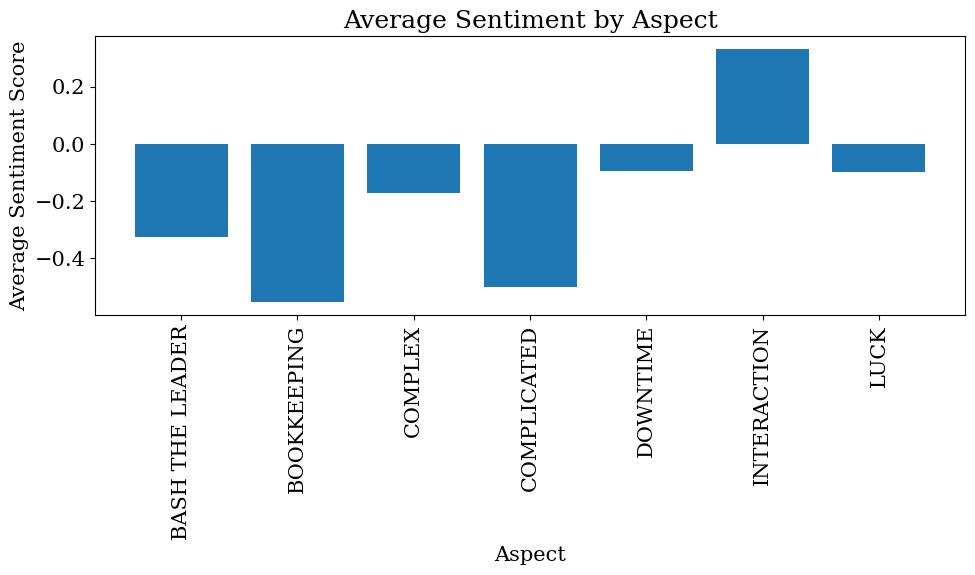

In [ ]:
avg_sentiment = aggregated_sentiment_df.groupby('aspect')['overall_sentiment_score'].mean()

plt.figure(figsize=(10, 6))
plt.bar(avg_sentiment.index, avg_sentiment.values)
plt.xlabel('Aspect')
plt.ylabel('Average Sentiment Score')
_ = plt.title('Average Sentiment by Aspect')
plt.xticks(rotation=90)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
table_df = aggregated_sentiment_df.pivot(index='game_id', columns='aspect', values='overall_sentiment_score')
table_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


aspect,BASH THE LEADER,BOOKKEEPING,COMPLEX,COMPLICATED,DOWNTIME,INTERACTION,LUCK
game_id,,,,,,,
115746,NaN,NaN,-0.330421,-0.554163,0.088960,0.237877,-0.011747
161936,NaN,-0.636805,-0.095942,-0.409751,0.390302,0.701906,-0.211527
167791,-0.230968,-0.378811,-0.107118,-0.548385,-0.426372,-0.275284,-0.158856
174430,NaN,-0.558110,-0.162028,-0.479919,-0.148768,0.167391,0.010273
187645,NaN,-0.911755,-0.115653,-0.540902,0.241462,0.618400,-0.139765
224517,NaN,NaN,-0.206474,-0.542630,-0.445822,0.770348,-0.039934
233078,-0.418246,-0.363805,-0.248325,-0.522677,-0.242006,0.655023,-0.131849
291457,NaN,-0.384688,-0.293908,-0.526991,-0.189133,0.325290,0.043775
316554,NaN,NaN,0.080273,-0.209959,0.008628,0.576394,-0.189803


LABELLING THE COMMENTS BASED ON THE PROVIDED ASPECTS



In [ ]:
comments_df.loc[:, 'ASPECT'] = comments_df['value'].apply(lambda x: idx_extractor(x, aspects))

In [ ]:
# Check unique aspects after assignment
print("Unique aspects found in comments:")
print(comments_df['ASPECT'].unique())

Unique aspects found in comments:
[None 'DOWNTIME' 'INTERACTION' 'COMPLEX' 'LUCK' 'COMPLICATED'
 'BOOKKEEPING' 'BASH THE LEADER']


In [ ]:
lcomments_df = print(comments_df[['value', 'ASPECT']])

                                                  value    ASPECT
0     SLEEVED[IMG]https://cf.geekdo-static.com/mbs/m...      None
1                                                     G      None
2     Great game, full controllo of your strategy th...      None
3                                         Location: MSK      None
4     Very clever game, enjoyable overall.  Plus poi...  DOWNTIME
...                                                 ...       ...
4943                                              co-op      None
4944                       Nice for young / new players      None
4945  Only played the beginning scenarios with my el...      None
4948  Too hard under the rules in the game and a bit...      None
4949                              Fiddly and repetitive      None

[59417 rows x 2 columns]


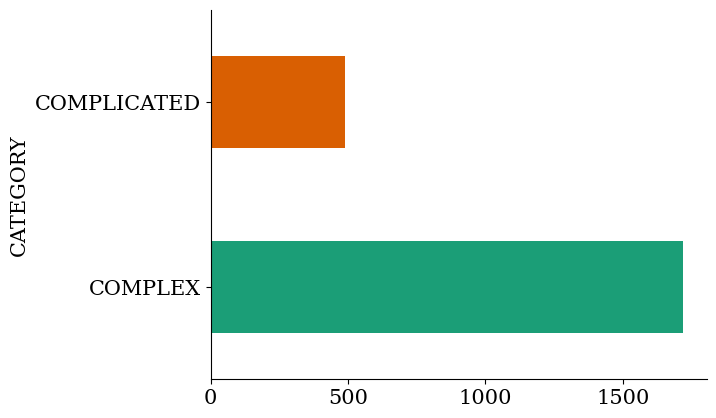

In [ ]:
import seaborn as sns
comments_df.groupby('CATEGORY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

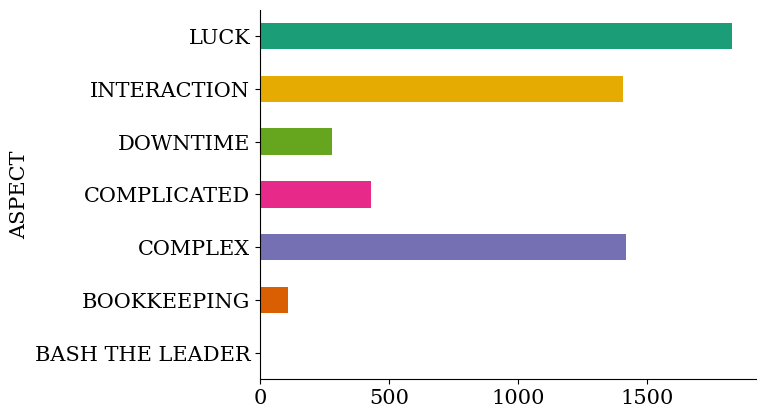

In [ ]:
#aspect
comments_df.groupby('ASPECT').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Filter comments where either ASPECT or CATEGORY is not null
filtered_comments = comments_df[(comments_df['ASPECT'].notnull())]

print(filtered_comments[['value', 'ASPECT']])


                                                  value       ASPECT
4     Very clever game, enjoyable overall.  Plus poi...     DOWNTIME
5     Brilliant!  Fits right into my wheelhouse all ...  INTERACTION
9     The game itself is not interesting enough to l...  INTERACTION
18    This is a near-perfect board game because...  ...  INTERACTION
20    Excellent and highly interactive game. Probabl...      COMPLEX
...                                                 ...          ...
4867  X2  Yum, yum! This game set out to be a stream...  INTERACTION
4872  I like the game, but it's not my favorite craw...      COMPLEX
4894  This fixed many problems that I found with Mag...      COMPLEX
4901  Interested in Selling, too complex and reliant...      COMPLEX
4942  It really is astounding that people are able t...      COMPLEX

[5475 rows x 2 columns]


ABSA for the game 115746: War of the Ring:second edition


In [ ]:
game_id = 115746
filtered_comments_df = comments_df[comments_df['boardgame_id'] == game_id]

# sentiment analysis to each comment
filtered_comments_df['overall_sentiment_label'] = filtered_comments_df['value'].apply(lambda x: analyze_overall_sentiment(x)[0])
filtered_comments_df['overall_sentiment_score'] = filtered_comments_df['value'].apply(lambda x: analyze_overall_sentiment(x)[1])


<ipython-input-23-91954bc0bf00>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_comments_df['overall_sentiment_label'] = filtered_comments_df['value'].apply(lambda x: analyze_overall_sentiment(x)[0])
<ipython-input-23-91954bc0bf00>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_comments_df['overall_sentiment_score'] = filtered_comments_df['value'].apply(lambda x: analyze_overall_sentiment(x)[1])


In [ ]:
# List of aspects to analyze
aspects = ['luck', 'bookkeeping', 'downtime', 'interaction', 'bash the leader', 'complex', 'complicated']

# Apply ABSA for each aspect
for aspect in aspects:
    aspect_labels = []
    aspect_scores = []

    for comment in filtered_comments_df['value']:
        sentiment_scores = analyze_aspect_sentiment(comment, aspect)
        aspect_labels.append(max(sentiment_scores, key=sentiment_scores.get))  # Get the label with the highest score
        aspect_scores.append(sentiment_scores[max(sentiment_scores, key=sentiment_scores.get)])  # Get the highest score

    filtered_comments_df[f'{aspect}_sentiment_label'] = aspect_labels
    filtered_comments_df[f'{aspect}_sentiment_score'] = aspect_scores


print(filtered_comments_df.head())

<ipython-input-25-ba069bb050c6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_comments_df[f'{aspect}_sentiment_label'] = aspect_labels
<ipython-input-25-ba069bb050c6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_comments_df[f'{aspect}_sentiment_score'] = aspect_scores
<ipython-input-25-ba069bb050c6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

            username  rating  \
0               0rlo     9.5   
1          1Peter567     9.0   
2  1point21gigawatts     NaN   
3          2624johnm     9.0   
4        360_Piranha    10.0   

                                               value  boardgame_id LANGUAGE  \
0  -0,5 for too soft plastic figures.  They are d...        115746       en   
1                            Organized; FoldedSpace.        115746       en   
2                        BGG Spring 2019 VFM (trade)        115746       en   
3  Great strategy game but slightly biased agains...        115746       en   
4  One of the best thematic implementations... yo...        115746       en   

   PROBABILITY ASPECT CATEGORY overall_sentiment_label  \
0     1.000000   None     None                negative   
1     0.800493   None     None                 neutral   
2     0.362988   None     None                 neutral   
3     1.000000   None     None                negative   
4     1.000000   None     None            

<ipython-input-25-ba069bb050c6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_comments_df[f'{aspect}_sentiment_label'] = aspect_labels
<ipython-input-25-ba069bb050c6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_comments_df[f'{aspect}_sentiment_score'] = aspect_scores


In [ ]:
filtered_comments_df.to_csv('filtered_comments_with_sentiments.csv', index=False)
from google.colab import files


files.download('filtered_comments_with_sentiments.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sentiment distribution for aspect 'luck':
luck_sentiment_label
positive    1426
neutral     1400
negative     409
Name: count, dtype: int64



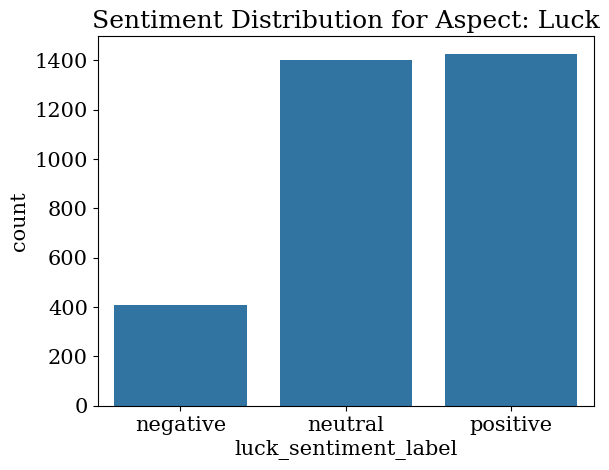

Sentiment distribution for aspect 'bookkeeping':
bookkeeping_sentiment_label
neutral     1830
positive    1071
negative     334
Name: count, dtype: int64



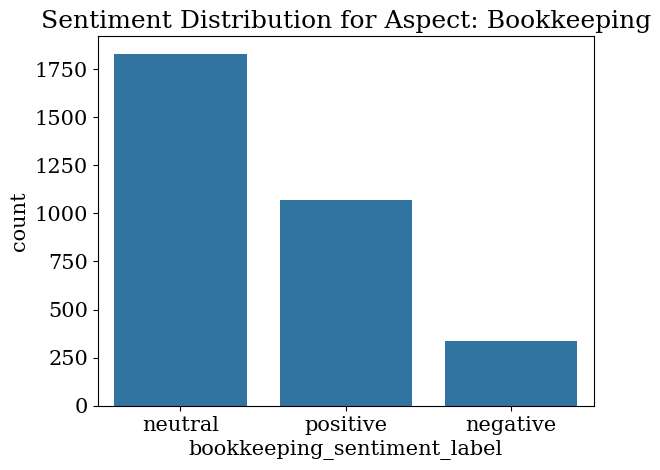

Sentiment distribution for aspect 'downtime':
downtime_sentiment_label
positive    1399
neutral     1011
negative     825
Name: count, dtype: int64



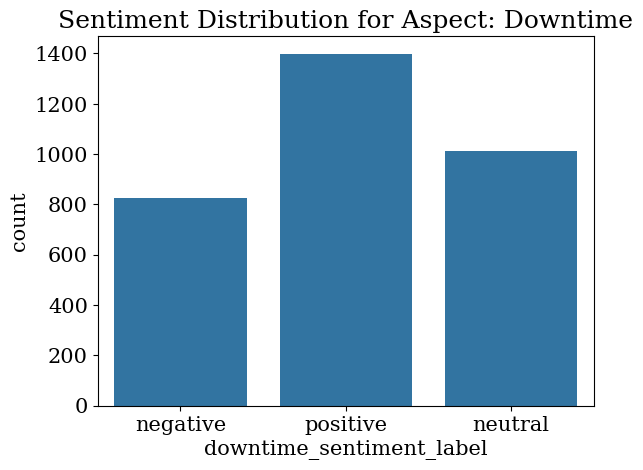

Sentiment distribution for aspect 'interaction':
interaction_sentiment_label
positive    1554
neutral     1300
negative     381
Name: count, dtype: int64



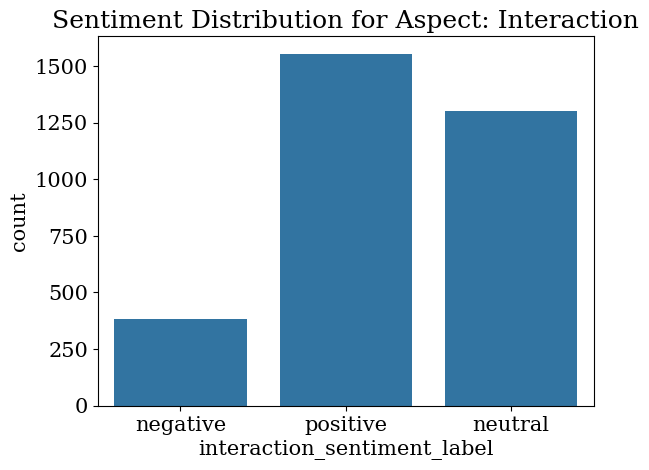

Sentiment distribution for aspect 'bash the leader':
bash the leader_sentiment_label
negative    1340
positive    1140
neutral      755
Name: count, dtype: int64



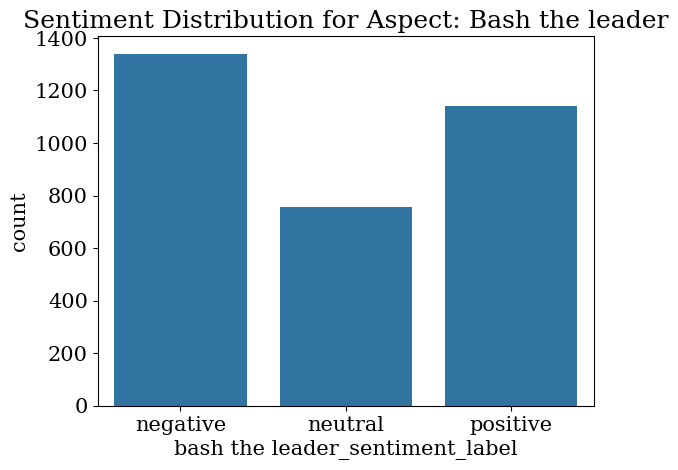

Sentiment distribution for aspect 'complex':
complex_sentiment_label
neutral     1325
positive    1017
negative     893
Name: count, dtype: int64



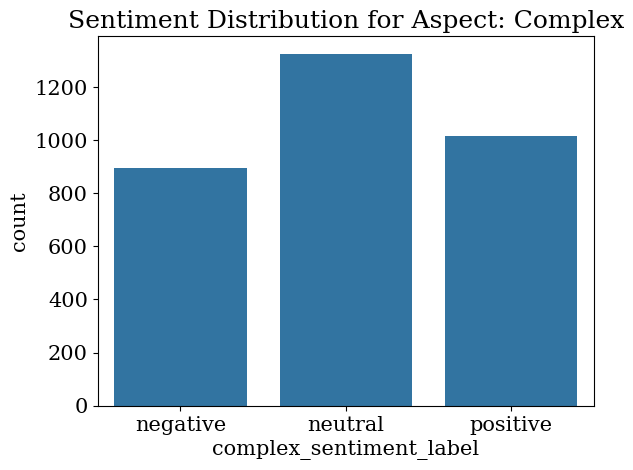

Sentiment distribution for aspect 'complicated':
complicated_sentiment_label
negative    2379
positive     593
neutral      263
Name: count, dtype: int64



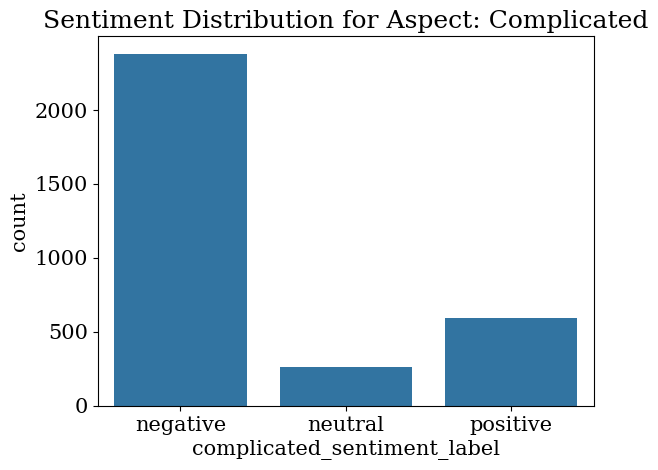

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


for aspect in aspects:
    sentiment_counts = filtered_comments_df[f'{aspect}_sentiment_label'].value_counts()
    print(f"Sentiment distribution for aspect '{aspect}':\n{sentiment_counts}\n")


    sns.countplot(x=f'{aspect}_sentiment_label', data=filtered_comments_df)
    plt.title(f"Sentiment Distribution for Aspect: {aspect.capitalize()}")
    plt.show()
